# Feedback analysis using radiative kernels

```{image} ../images/ProjectPythia_Logo_Final-01-Blue.svg
:alt: Project Pythia Logo
:width: 250px
```

---

## Overview

This notebook details all of the steps required to perform a radiative kernel analysis.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Loading CMIP6 data with Intake-ESM](https://projectpythia.org/cmip6-cookbook/notebooks/foundations/intake-esm) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro) | Necessary |  |

- **Time to learn**: 60 minutes

---

## Imports

In [63]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import intake
import s3fs
import fsspec
import glob

## Loading in required data

### Climate model output

In this example, we will perform the analysis on a single model from the CMIP6 ensemble, CESM2. The simplest way to calculate feedbacks is to take differences between two climate states, as opposed to regressions. Here we use runs with:
- preindustrial conditions (`piControl`) as the control climate
- instantaneously quadrupled CO$_2$ (`abrupt-4xCO2`) as the perturbed climate

We will use CMIP6 data hosted on Pangeo's Google Cloud Storage:

In [2]:
cat_url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'
col = intake.open_esm_datastore(cat_url)

The fields (and CMIP names) required to calculate each feedback are:
- Albedo: upwelling and downwelling SW radiation at the surface (`rsus` and `rsds`)
- Temperature (Planck and lapse rate): air temperature (`ta`) and surface temperature (`ts`)
- Water vapor: specific humidity (`hus`) and air temperature
- SW CRE: Net SW radiation at TOA (down `rsdt` minus up `rsut`) and clear-sky versions (down, which is the same, minus up `rsutcs`)
- LW CRE: Net LW radiation at TOA (`rlut`) and the clear-sky version (`rlutcs`)

The cloud feedbacks require the results from the other feedbacks to correct for noncloud contributions to the CREs.

We will also need near-surface air temperature (`tas`) for calculating the change in global mean surface temperature (GMST).

In [3]:
cat = col.search(activity_id='CMIP', experiment_id=['piControl', 'abrupt-4xCO2'], table_id='Amon', source_id='CESM2', 
                 variable_id=['rsus', 'rsds', 'ta', 'ts', 'hus', 'rsdt', 'rsut', 'rsutcs', 'rlut', 'rlutcs', 'tas'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,rsutcs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
1,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
2,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,rsus,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
3,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,ta,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
4,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
5,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
6,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
7,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
8,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320
9,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,rlutcs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,<NA>,20190320


In [4]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
ctrl = dset_dict['CMIP.NCAR.CESM2.piControl.Amon.gn']

In [6]:
ctrl

<xarray.Dataset> Size: 150GB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 14400, lat: 192,
                     lon: 288, nbnd: 2, plev: 19)
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float32 2kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float32 2kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 115kB 0001-01-15 12:00:00 ... 1200-12-15 12...
    time_bnds       (time, nbnd) object 230kB dask.array<chunksize=(14400, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) object 8B None
  * plev            (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
Dimensions without coordinates: nbnd
Data variables:
    rsutcs          (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    rsut            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    rsus            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    ta              (member_id, dcpp_init_year, time, plev, lat, lon) float32 61GB dask.array<chunksize=(1, 1, 30, 19, 192, 288), meta=np.ndarray>
    hus             (member_id, dcpp_init_year, time, plev, lat, lon) float32 61GB dask.array<chunksize=(1, 1, 30, 19, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    rsdt            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    ts              (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    rsds            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    rlutcs          (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    rlut            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/54)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            48545.0
    case_id:                          3
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190320
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.piControl.Amon.gn

In [7]:
pert = dset_dict['CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn']

In [8]:
pert

<xarray.Dataset> Size: 125GB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 11988, lat: 192,
                     lon: 288, nbnd: 2, plev: 19)
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 96kB 0001-01-15 12:00:00 ... 0999-12-15 12:...
    time_bnds       (time, nbnd) object 192kB dask.array<chunksize=(11988, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) object 8B None
  * plev            (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
Dimensions without coordinates: nbnd
Data variables:
    rsds            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 671, 192, 288), meta=np.ndarray>
    rlutcs          (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 761, 192, 288), meta=np.ndarray>
    rlut            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 719, 192, 288), meta=np.ndarray>
    ts              (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 814, 192, 288), meta=np.ndarray>
    rsdt            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 982, 192, 288), meta=np.ndarray>
    rsus            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 703, 192, 288), meta=np.ndarray>
    rsut            (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 660, 192, 288), meta=np.ndarray>
    rsutcs          (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 771, 192, 288), meta=np.ndarray>
    ta              (member_id, dcpp_init_year, time, plev, lat, lon) float32 50GB dask.array<chunksize=(1, 1, 49, 19, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 823, 192, 288), meta=np.ndarray>
    hus             (member_id, dcpp_init_year, time, plev, lat, lon) float32 50GB dask.array<chunksize=(1, 1, 39, 19, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    hybrid
    branch_time_in_child:             -182500.0
    branch_time_in_parent:            182865.0
    case_id:                          46
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190927
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn

### Radiative forcing data

To calculate the cloud feedback, we will need the effective radiative forcing (ERF) resulting from 4xCO2, which we can find under another project, RFMIP:

In [9]:
rf_cat = col.search(activity_id='RFMIP', experiment_id='piClim-4xCO2', source_id='CESM2')
rf_cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,RFMIP,NCAR,CESM2,piClim-4xCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/RFMIP/NCAR/CESM2/piClim-4xCO2...,<NA>,20190815
1,RFMIP,NCAR,CESM2,piClim-4xCO2,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/RFMIP/NCAR/CESM2/piClim-4xCO2...,<NA>,20190815
2,RFMIP,NCAR,CESM2,piClim-4xCO2,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/RFMIP/NCAR/CESM2/piClim-4xCO2...,<NA>,20190815
3,RFMIP,NCAR,CESM2,piClim-4xCO2,r1i1p1f1,Amon,rlut,gn,gs://cmip6/CMIP6/RFMIP/NCAR/CESM2/piClim-4xCO2...,<NA>,20190815


In [10]:
rf_dset_dict = rf_cat.to_dataset_dict(zarr_kwargs={'consolidated': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
forcing = rf_dset_dict['RFMIP.NCAR.CESM2.piClim-4xCO2.Amon.gn']
forcing

<xarray.Dataset> Size: 319MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 360, lat: 192,
                     lon: 288, nbnd: 2)
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 3kB 0001-01-15 12:00:00 ... 0030-12-15 12:0...
    time_bnds       (time, nbnd) object 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) object 8B None
Dimensions without coordinates: nbnd
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 80MB dask.array<chunksize=(1, 1, 180, 192, 288), meta=np.ndarray>
    rsut            (member_id, dcpp_init_year, time, lat, lon) float32 80MB dask.array<chunksize=(1, 1, 180, 192, 288), meta=np.ndarray>
    rsdt            (member_id, dcpp_init_year, time, lat, lon) float32 80MB dask.array<chunksize=(1, 1, 180, 192, 288), meta=np.ndarray>
    rlut            (member_id, dcpp_init_year, time, lat, lon) float32 80MB dask.array<chunksize=(1, 1, 180, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      RFMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            182500.0
    case_id:                          1528
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190815
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           RFMIP.NCAR.CESM2.piClim-4xCO2.Amon.gn

### Radiative kernels

We will load in radiative kernels from Project Pythia's storage on JetStream2. We will be using the ERA5 kernels [(Huang & Huang 2023)](https://essd.copernicus.org/articles/15/3001/2023/).

In [12]:
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/ClimKern'
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))
patternKern = f's3://{path}/kernels/ERA5/*.nc'
patternTutorial = f's3://{path}/tutorial_data/*.nc'
filesKern = sorted(fs.glob(patternKern))
filesTutorial = sorted(fs.glob(patternTutorial))
fs.invalidate_cache() # This is necessary to deal with peculiarities of objects served from jetstream2
filesetKern = [fs.open(file) for file in filesKern[0:2]]
filesetTutorial = [fs.open(file) for file in filesKern[0:2]]

We will use the more common TOA kernels.

In [13]:
filesKern

['pythia/ClimKern/kernels/ERA5/SFC_ERA5_Kerns.nc',
 'pythia/ClimKern/kernels/ERA5/TOA_ERA5_Kerns.nc']

As we will see in a moment, the naming convention for months as calculated from Xarray's `.groupby()` method ("month", 1-12) is different from what is used in the kernel dataset ("time", 0-11), so we need to align them:

In [14]:
data_kern = xr.open_dataset(filesetKern[1])
data_kern['time'] = data_kern['time'] + 1
data_kern = data_kern.rename({'time': 'month'})
data_kern

<xarray.Dataset> Size: 228MB
Dimensions:   (month: 12, plev: 37, lat: 73, lon: 144)
Coordinates:
  * plev      (plev) float32 148B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * lat       (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon       (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lwclr_t   (month, plev, lat, lon) float64 37MB ...
    lw_t      (month, plev, lat, lon) float64 37MB ...
    lwclr_q   (month, plev, lat, lon) float64 37MB ...
    lw_q      (month, plev, lat, lon) float64 37MB ...
    swclr_q   (month, plev, lat, lon) float64 37MB ...
    sw_q      (month, plev, lat, lon) float64 37MB ...
    swclr_a   (month, lat, lon) float64 1MB ...
    sw_a      (month, lat, lon) float64 1MB ...
    lwclr_ts  (month, lat, lon) float64 1MB ...
    lw_ts     (month, lat, lon) float64 1MB ...

Let's take a look at some of these kernels. First, the albedo kernel, annually averaged:

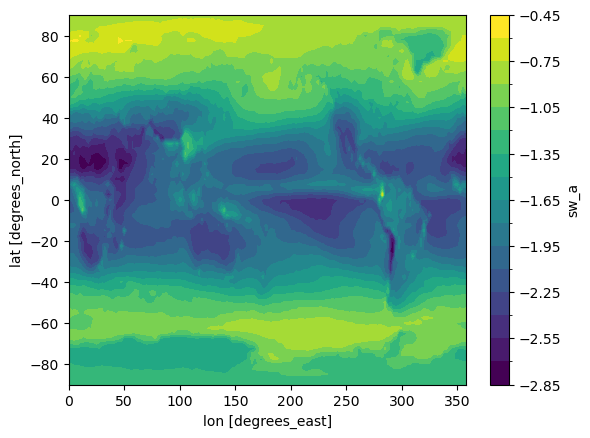

In [15]:
data_kern.sw_a.mean(dim='month').plot.contourf(levels=20)

And the LW water vapor kernel, annually and zonally averaged:

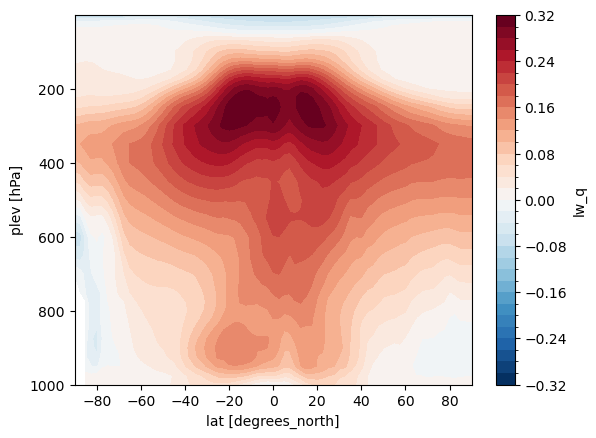

In [16]:
data_kern.lw_q.mean(dim=['month', 'lon']).plot.contourf(levels=40, yincrease=False)

## Preparing data for analysis

Define a function for taking global averages:

In [17]:
def global_average(data):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['lat', 'lon'], skipna=True)

To get a general idea of how the climate changes in these runs, we can plot the 12-month rolling GMST for the two runs:

In [18]:
gmst_ctrl = global_average(ctrl.tas.rolling(time=12, center=True).mean())

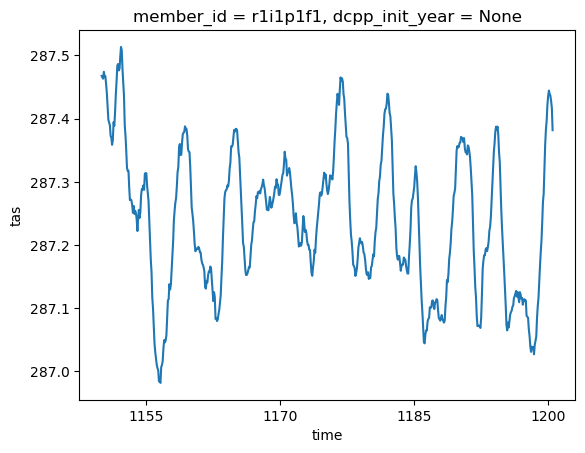

In [19]:
gmst_ctrl.sel(time=slice('1150', '1200')).plot()

In [20]:
gmst_pert = global_average(pert.tas.rolling(time=12, center=True).mean())

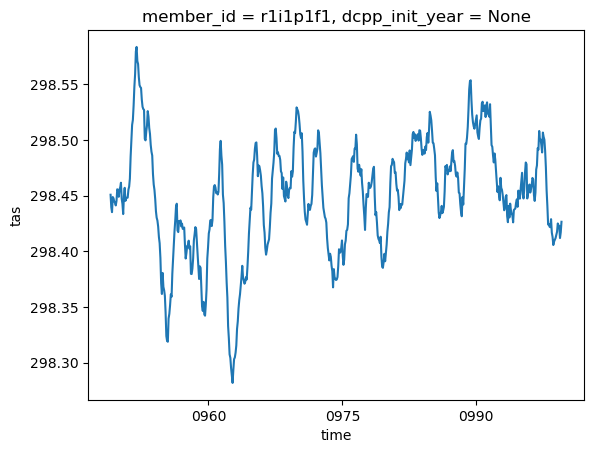

In [21]:
gmst_pert.sel(time=slice('0949', '0999')).plot()

### Calculating the two climate states

Ideally, we would want to compare two equilibrated climates, but since that is usually not possible with standard-length CMIP experiments, we will simply use the monthly climatology over the last 50 years available for each run, which is close enough to equilibrium. The pressure coordinates are in Pa, so let's convert them to hPa to match the kernels:

In [22]:
ctrl_state = ctrl.sel(time=slice('1150', '1200')).groupby('time.month').mean(dim='time').squeeze()
pert_state = pert.sel(time=slice('0949', '0999')).groupby('time.month').mean(dim='time').squeeze()

ctrl_state['plev'] = ctrl_state['plev']/100
pert_state['plev'] = pert_state['plev']/100

In [23]:
pert_state

<xarray.Dataset> Size: 125MB
Dimensions:         (month: 12, lat: 192, lon: 288, plev: 19, nbnd: 2)
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None
  * plev            (plev) float64 152B 1e+03 925.0 850.0 700.0 ... 10.0 5.0 1.0
  * month           (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnd
Data variables:
    rsds            (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    rlutcs          (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    rlut            (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    ts              (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    rsdt            (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    rsus            (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    rsut            (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    rsutcs          (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    ta              (month, plev, lat, lon) float32 50MB dask.array<chunksize=(1, 19, 192, 288), meta=np.ndarray>
    tas             (month, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    hus             (month, plev, lat, lon) float32 50MB dask.array<chunksize=(1, 19, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    hybrid
    branch_time_in_child:             -182500.0
    branch_time_in_parent:            182865.0
    case_id:                          46
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190927
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn

We will need the change in GMST in order to calculate the feedbacks:

In [24]:
dgmst = global_average(pert_state.tas - ctrl_state.tas).mean(dim='month')
dgmst.load()

<xarray.DataArray 'tas' ()> Size: 8B
array(11.20986507)
Coordinates:
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None

### Regridding

The model output and kernels are not on the same grid, so we will regrid the kernel dataset to the model's grid using the regridding package `xesmf`. For reusability, let's define a function to regrid data:

In [25]:
def regrid(ds_in, regrid_to, method='bilinear'):
    regridder = xe.Regridder(ds_in, regrid_to, method=method, periodic=True, ignore_degenerate=True)
    ds_out = regridder(ds_in)
    return ds_out

In [26]:
regr_kernels = regrid(data_kern, pert_state)

In [27]:
regr_kernels

<xarray.Dataset> Size: 1GB
Dimensions:   (month: 12, plev: 37, lat: 192, lon: 288)
Coordinates:
  * plev      (plev) float32 148B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    lwclr_t   (month, plev, lat, lon) float64 196MB nan nan ... -0.7508 -0.7508
    lw_t      (month, plev, lat, lon) float64 196MB nan nan ... -0.7508 -0.7508
    lwclr_q   (month, plev, lat, lon) float64 196MB nan nan ... -0.1097 -0.1097
    lw_q      (month, plev, lat, lon) float64 196MB nan nan ... -0.1099 -0.1099
    swclr_q   (month, plev, lat, lon) float64 196MB nan nan nan ... nan nan nan
    sw_q      (month, plev, lat, lon) float64 196MB nan nan nan ... nan nan nan
    swclr_a   (month, lat, lon) float64 5MB -4.095 -4.095 -4.095 ... 0.0 0.0 0.0
    sw_a      (month, lat, lon) float64 5MB -3.853 -3.853 -3.853 ... 0.0 0.0 0.0
    lwclr_ts  (month, lat, lon) float64 5MB -1.577 -1.577 ... -1.444 -1.444
    lw_ts     (month, lat, lon) float64 5MB -1.294 -1.294 ... -0.7787 -0.7787
Attributes:
    regrid_method:  bilinear

Check that the kernels look as expected:

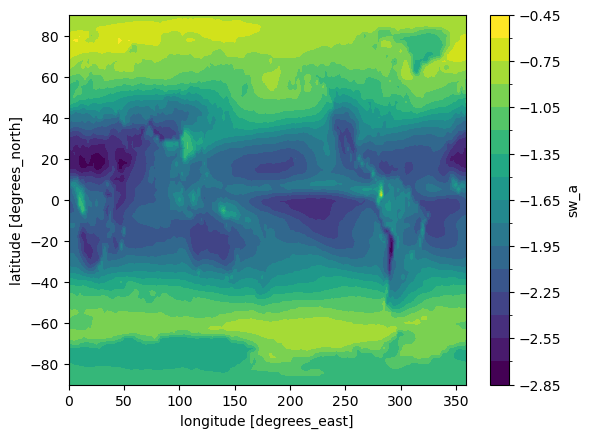

In [28]:
regr_kernels.sw_a.mean(dim='month').plot.contourf(levels=20)

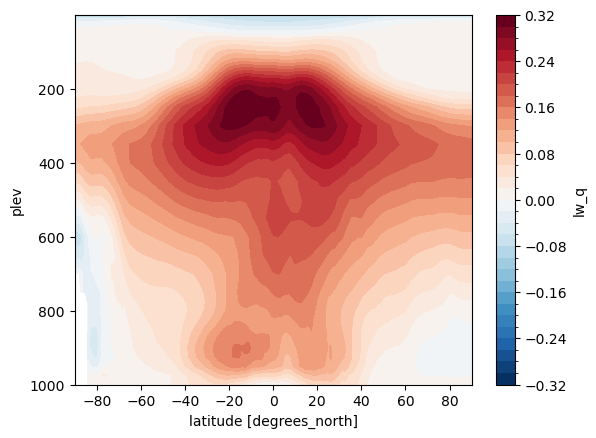

In [29]:
regr_kernels.lw_q.mean(dim=['month', 'lon']).plot.contourf(levels=40, yincrease=False)

## Calculating feedbacks

For all noncloud feedbacks, we will calculate both the all-sky and clear-sky (indicated by `clr` in the kernel dataset here) change in TOA radiation $\Delta R$. To do this, we just use the clear-sky version of the kernel in place of the all-sky kernel. The differences $\Delta R^\mathrm{clear}_X-\Delta R^\mathrm{all}_X$ for each feedback $X$ will be used to adjust the CREs into proper cloud feedbacks.

For the feedbacks involving fields that are a function of pressure (i.e., temperature and water vapor), we need to mask out the stratosphere. In this notebook, we will approximate this using a function that masks above 100 hPa at the equator and linearly decreases to 300 hPa at the poles:

In [30]:
def tropo_mask(ds):
    return ds.where(ds.plev > ((200/90)*abs(ds.lat) + 100))

Compare:

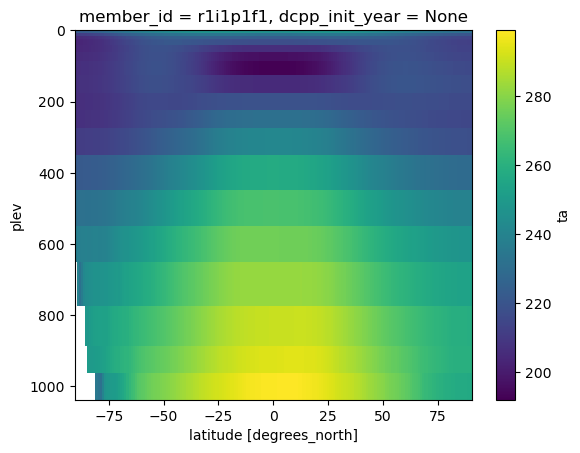

In [31]:
ctrl_state.ta.mean(dim=['month', 'lon']).plot(yincrease=False)

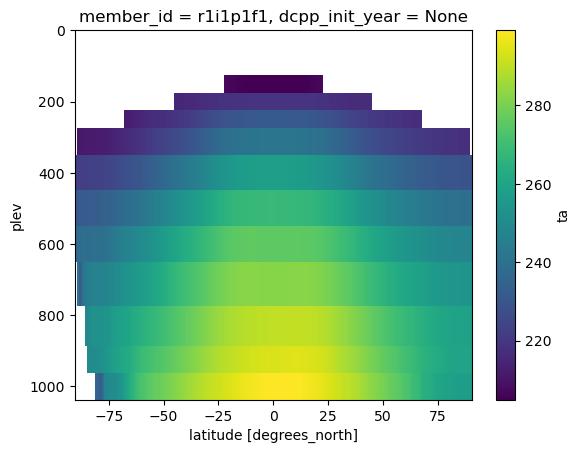

In [32]:
tropo_mask(ctrl_state.ta.mean(dim=['month', 'lon'])).plot(yincrease=False)

### Surface albedo

The first step is to calculate the change in albedo between the control and perturbed climates. The surface albedo $\alpha$ is defined as the fraction of downwelling solar radiation at the surface that is reflected back up. That is,

$$\alpha=\frac{S^\uparrow_\mathrm{s}}{S^\downarrow_\mathrm{s}}=\frac{\mathtt{rsus}}{\mathtt{rsds}}$$

In [33]:
alb_ctrl = (ctrl_state.rsus/ctrl_state.rsds.where(ctrl_state.rsds > 0)).fillna(0)
alb_pert = (pert_state.rsus/pert_state.rsds.where(ctrl_state.rsds > 0)).fillna(0)

Note that we avoided dividing by zero by masking regions where `rsds` = 0 and filling in the resulting `nan`s with 0. Now, take the difference:

In [34]:
dalb = alb_pert - alb_ctrl

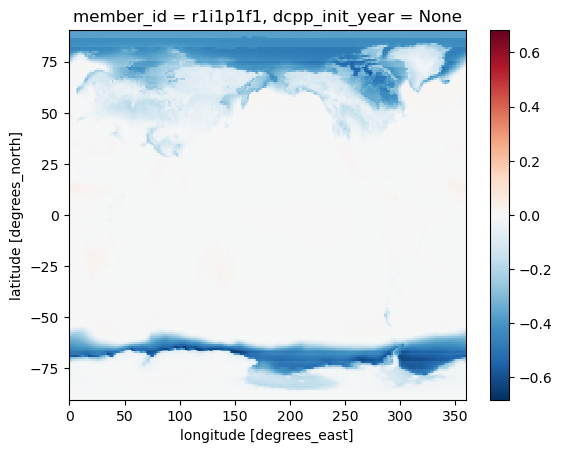

In [35]:
dalb.mean(dim='month').plot()

By multiplying the change in albedo with the albedo kernel, we get the change in TOA radiation (in units W m$^{-2}$) resulting from that change in albedo:

$$\Delta R_\alpha=K_\alpha\cdot\Delta\alpha$$

We also need to multiply by 100 to get albedo as a percentage.

In [36]:
dSW_alb = regr_kernels.sw_a * dalb * 100
dSW_alb_clr = regr_kernels.swclr_a * dalb * 100

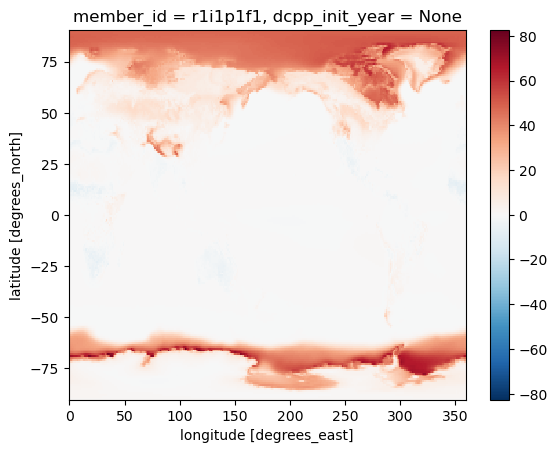

In [37]:
dSW_alb.mean(dim='month').plot()

The feedback in units W m$^{-2}$ K$^{-1}$ is then calculated by normalizing this change in TOA radiation by the change in GMST:

$$\lambda_\alpha=\frac{\Delta R_\alpha}{\Delta T_\mathrm{s}}$$

In [38]:
alb_feedback = dSW_alb/dgmst

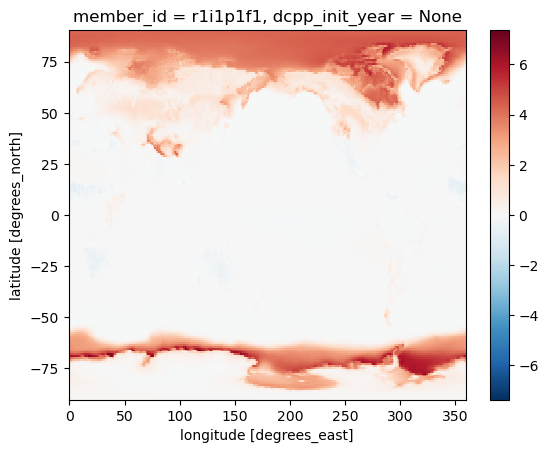

In [39]:
alb_feedback.mean(dim='month').plot()

Taking the global and annual average, we get a final value of about $0.35$ W m$^{-2}$ K$^{-1}$:

In [40]:
global_average(alb_feedback.mean(dim='month')).load()

<xarray.DataArray ()> Size: 8B
array(0.35193204)
Coordinates:
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None

### Temperature

The temperature feedback is decomposed into Planck and lapse rate feedbacks, but first, we can calculate the change in TOA LW radiation resulting from changes in surface (`ts`) and air (`ta`) temperature. The first step is calculating the changes in surface and air temperature:

In [41]:
dts = pert_state.ts - ctrl_state.ts
dta = pert_state.ta - ctrl_state.ta

Then the change in TOA radiation using the kernels:

$$\Delta R_{T_\mathrm{s}}=K_{T_\mathrm{s}}\cdot\Delta T_\mathrm{s}$$

And for feedbacks that involve functions of pressure, we sum over the pressure levels:

$$\Delta R_T=\sum_p K_T(p)\cdot\Delta T(p)$$

In [42]:
dLW_ts = regr_kernels.lw_ts * dts
dLW_ts_clr = regr_kernels.lwclr_ts * dts

dLW_ta = (regr_kernels.lw_t * tropo_mask(dta)).sum(dim='plev', skipna=True)
dLW_ta_clr = (regr_kernels.lwclr_t * tropo_mask(dta)).sum(dim='plev', skipna=True)

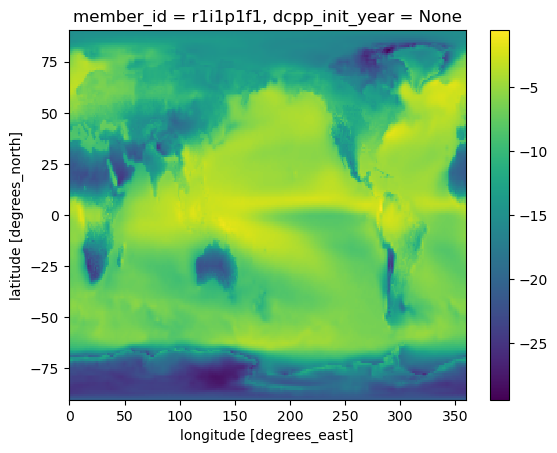

In [43]:
dLW_ts.mean(dim='month').plot()

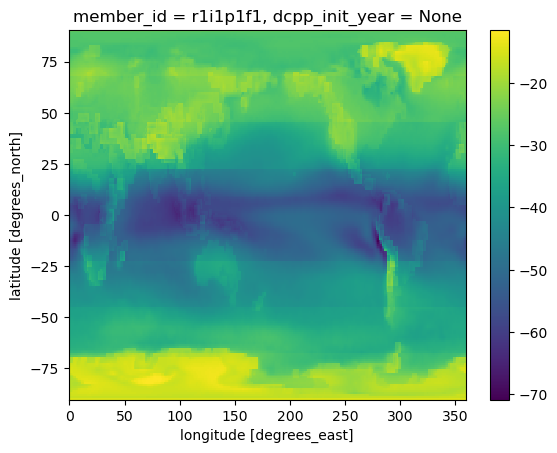

In [44]:
dLW_ta.mean(dim='month').plot()

The full temperature feedback is the sum of these, normalized by the change in GMST:

$$\lambda_T=\frac{\Delta R_{T_\mathrm{s}}+\Delta R_T}{\Delta T_\mathrm{s}}$$

In [45]:
t_feedback = (dLW_ta + dLW_ts)/dgmst

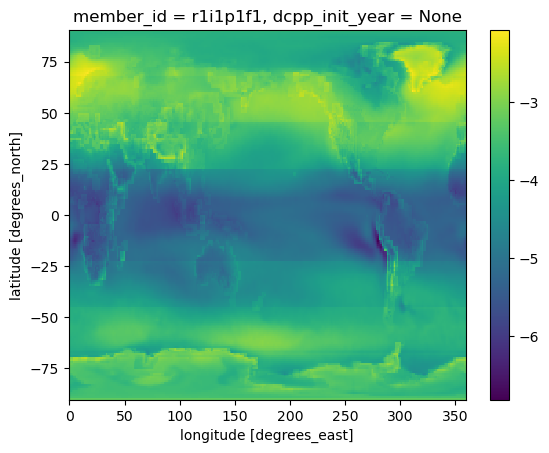

In [46]:
t_feedback.mean(dim='month').plot()

For the annual and global average, we get about $-4.3$ W m$^{-2}$ K$^{-1}$:

In [47]:
global_average(t_feedback.mean(dim='month')).load()

<xarray.DataArray ()> Size: 8B
array(-4.29685289)
Coordinates:
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None

#### Planck

There are two components to the Planck feedback:
1. The change in TOA radiation due to the surface warming (calculated in the previous section)
2. The change in TOA radiation due to a vertically-uniform warming

We assume a vertically-uniform warming based on the surface temperature. To do this, project the surface warming into the vertical. One way to do this with Xarray is:

In [48]:
dts_3d = dts.expand_dims(dim={'plev': dta.plev})

Check the vertical profile:

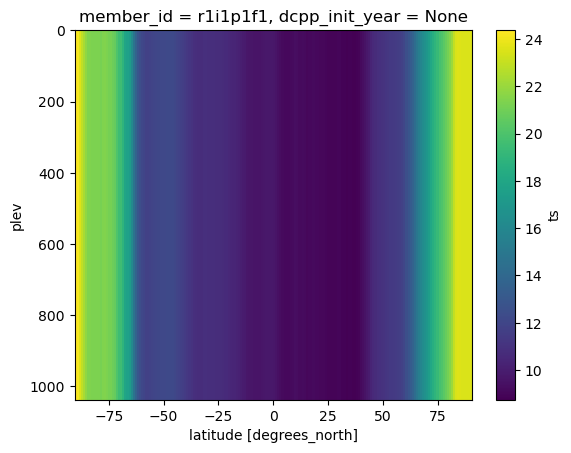

In [49]:
dts_3d.mean(dim=['month', 'lon']).plot(yincrease=False)

In [50]:
dLW_dts_3d = (regr_kernels.lw_t * tropo_mask(dts_3d)).sum(dim='plev', skipna=True)

The sum of the two components divided by the change in GMST is the Planck feedback:

In [51]:
planck_feedback = (dLW_ts + dLW_dts_3d)/dgmst

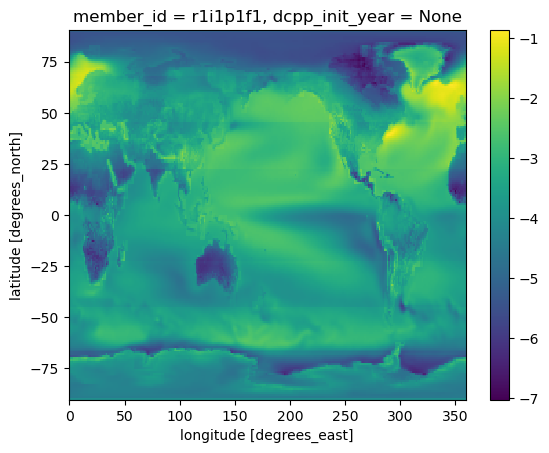

In [52]:
planck_feedback.mean(dim='month').plot()

Annual and global average: $-3.6$ W m$^{-2}$ K$^{-1}$.

In [53]:
global_average(planck_feedback.mean(dim='month')).load()

<xarray.DataArray ()> Size: 8B
array(-3.55439678)
Coordinates:
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None

#### Lapse rate

The lapse rate feedback is calculated using the vertically-nonuniform warming. To do this, we subtract the surface temperature change that we projected into the vertical from the air temperature change, also masking out the stratosphere:

In [54]:
dt_lapserate = tropo_mask(dta - dts_3d)

In [55]:
dt_lapserate

<xarray.DataArray (month: 12, plev: 19, lat: 192, lon: 288)> Size: 50MB
dask.array<where, shape=(12, 19, 192, 288), dtype=float32, chunksize=(1, 19, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None
  * plev            (plev) float64 152B 1e+03 925.0 850.0 700.0 ... 10.0 5.0 1.0
  * month           (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Multiply by the LW temperature kernel and sum over the vertical:

In [56]:
dLW_lapserate = (regr_kernels.lw_t * tropo_mask(dt_lapserate)).sum(dim='plev', skipna=True)

Divide by change in GMST to get the feedback:

In [57]:
lapserate_feedback = dLW_lapserate/dgmst

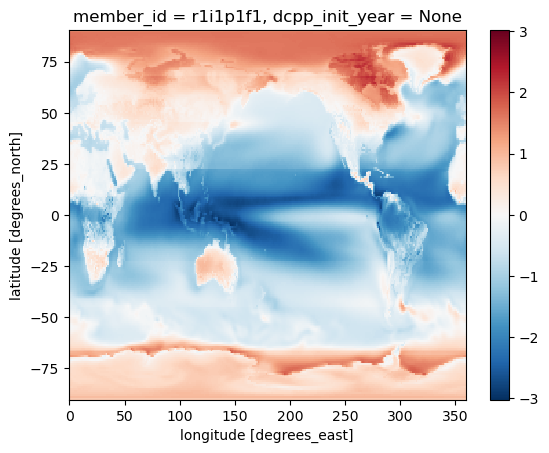

In [58]:
lapserate_feedback.mean(dim='month').plot()

Calculate global average:

In [59]:
global_average(lapserate_feedback.mean(dim='month')).load()

<xarray.DataArray ()> Size: 8B
array(-0.74900439)
Coordinates:
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None

The sum of the Planck and lapse rate feedbacks should equal the full temperature feedback we calculated first:
$$\lambda_{\mathrm{Planck}}+\lambda_{\mathrm{LR}}\approx-3.55-0.75=-4.3\approx\lambda_T$$

### Water vapor

When calculating the water vapor feedbacks, we need to normalize the kernels by the log change in specific humidity per unit warming, $\partial\ln q/\partial T$. First, we will define a function to calculate the saturation specific humidity (Buck 1981). Note that we want temperature in deg C and pressure in hPa for these formulas to work.

In [83]:
def qs(t, p=None):
    t = t - 273.15
    # Get pressure in hPa
    p = t.plev/100
    
    # Saturation vapor pressure (liquid and ice)
    esl = (1.0007 + 3.46e-6 * p) * 6.1121 * np.exp((17.502 * t) / (240.97 + t))
    esi = (1.0003 + 4.18e-6 * p) * 6.1115 * np.exp((22.452 * t) / (272.55 + t))

    # Convert from vapor pressure to mixing ratio
    wsl = 0.622*esl/(p - esl)
    wsi = 0.622*esi/(p - esi)

    # Use liquid water when temp is above freezing
    ws = xr.where(t > 0, wsl, wsi)

    # Convert to specific humidity
    qs = ws/(1 + ws)

    return qs

We can use the $q$ and $T$ from the control and perturbed climates to approximate the normalization factor:

In [84]:
qs_ctrl = qs(ctrl.ta.squeeze())
qs_pert = qs(pert.ta.squeeze())

In [85]:
dlnqdT = (np.log(qs_pert) - np.log(qs_ctrl))/(pert.ta.squeeze() - ctrl.ta.squeeze())

In [90]:
dlnqdT

<xarray.DataArray (time: 11988, plev: 19, lat: 192, lon: 288)> Size: 101GB
dask.array<truediv, shape=(11988, 19, 192, 288), dtype=float64, chunksize=(30, 19, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time            (time) object 96kB 0001-01-15 12:00:00 ... 0999-12-15 12:...
  * plev            (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  object 8B None

#### Shortwave water vapor

In [89]:
regr_kernels.sw_q

<xarray.DataArray 'sw_q' (month: 12, plev: 37, lat: 192, lon: 288)> Size: 196MB
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 4.33152728e-04,  4.33152728e-04,  4.33152728e-04, ...,
           4.33152728e-04,  4.33152728e-04,  4.33152728e-04],
         [ 5.70465316e-04,  5.46369767e-04,  5.22220351e-04, ...,
           6.52359984e-04,  5.91804437e-04,  5.81170088e-04],
         [ 7.07753655e-04,  6.59566791e-04,  6.11272244e-04, ...,
           7.95248036e-04,  7.50428128e-04,  7.29161283e-04],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]],
      shape=(12, 37, 192, 288))
Coordinates:
  * plev     (plev) float32 148B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

#### Longwave water vapor

### Cloud

#### Cloud radiative effect (CRE)

In [61]:
ctrl_SWCRE = (-ctrl_state.rsut + ctrl_state.rsutcs)
pert_SWCRE = (-pert_state.rsut + pert_state.rsutcs)
dSWCRE = pert_SWCRE - ctrl_SWCRE

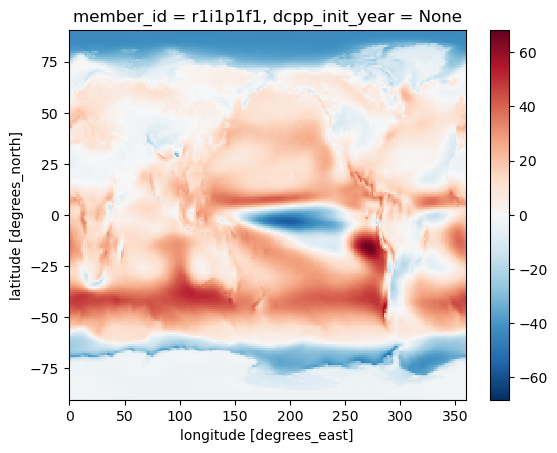

In [62]:
dSWCRE.mean(dim='month').plot()

#### Cloud feedback adjustments

### Net

---

## Summary

### What's next?


## Resources